To perform calibration of the Displaced-Diffusion model and SABR model, the primary objective is to achieve a match between the calibrated model implied volatilities and the implied volatilities observed in the market. An optimized function can be created to determine the optimal parameters which minimize the sum of squared error between the market implied volatilities and the implied volatilities calibrated from the Displaced-Diffusion and SABR models，which enables us to establish a robust and accurate model calibration process that is widely accepted in the financial industry.



 Using SABR as an example, defining

  \begin{equation*}
    \begin{split}
      \sigma_{\mbox{Mkt}}(K_1) - \mbox{SABR}(F, K_1, T, \alpha, 0.8, \rho, \nu) &= \epsilon_1 \\
      \sigma_{\mbox{Mkt}}(K_2) - \mbox{SABR}(F, K_2, T, \alpha, 0.8, \rho, \nu) &= \epsilon_2 \\
      \vdots&\\
      \sigma_{\mbox{Mkt}}(K_n) - \mbox{SABR}(F, K_n, T, \alpha, 0.8, \rho, \nu) &= \epsilon_n \\
    \end{split}
  \end{equation*}

We want to minimize the sum of squared error terms as follows:
  
  \begin{equation*}
    \begin{split}
      \min_{\substack{\alpha,\; \rho,\; \nu}} \;\sum_{i=1}^n \epsilon_i^2
    \end{split}
  \end{equation*}

We use the "least_squares" algorithm in "scipy" package to calibrate the SABR model parameters:


The main idea for DD model is the same.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq, least_squares, curve_fit,fsolve
%matplotlib inline
import warnings

In [2]:
swaption = pd.read_excel ('IR Data.xlsx', sheet_name='Swaption', skiprows = 2, header = 0)
swaption = swaption.iloc[0:15,0:13]
swaption.iloc[:, 2:] = swaption.iloc[:, 2:] / 100

In [3]:
swap = swaption.set_index(['Expiry', 'Tenor']) ## swaption implied volatilities

In [4]:
swap

-200bps  -150bps  -100bps   -50bps   -25bps     ATM  +25bps  \
Expiry Tenor                                                                
1Y     1Y     0.91570  0.62030  0.44130  0.31224  0.26182  0.2250  0.2096   
       2Y     0.83270  0.61240  0.46570  0.35807  0.31712  0.2872  0.2712   
       3Y     0.73920  0.56870  0.44770  0.35745  0.32317  0.2978  0.2829   
       5Y     0.55190  0.44640  0.36510  0.30242  0.27851  0.2607  0.2498   
       10Y    0.41180  0.35040  0.30207  0.26619  0.25351  0.2447  0.2398   
5Y     1Y     0.67800  0.49090  0.38400  0.31485  0.29060  0.2726  0.2604   
       2Y     0.57880  0.46410  0.39033  0.33653  0.31531  0.2983  0.2856   
       3Y     0.53430  0.44440  0.38180  0.33437  0.31536  0.2998  0.2876   
       5Y     0.41990  0.36524  0.32326  0.29005  0.27677  0.2660  0.2573   
       10Y    0.34417  0.30948  0.28148  0.25954  0.25136  0.2451  0.2399   
10Y    1Y     0.55160  0.44320  0.37368  0.32259  0.30210  0.2854  0.2731   
       2Y     0.51170  0.42900  0.37078  0.32622  0.30800  0.2928  0.2809   
       3Y     0.48220  0.41430  0.36400  0.32439  0.30796  0.2940  0.2827   
       5Y     0.40550  0.35891  0.32181  0.29144  0.27857  0.2674  0.2580   
       10Y    0.33601  0.30509  0.27978  0.25926  0.25086  0.2437  0.2376   

              +50bps  +100bps  +150bps  +200bps  
Expiry Tenor                                     
1Y     1Y     0.2140   0.2434  0.27488  0.30297  
       2Y     0.2684   0.2851  0.31025  0.33523  
       3Y     0.2780   0.2877  0.30725  0.32833  
       5Y     0.2456   0.2512  0.26536  0.28165  
       10Y    0.2382   0.2425  0.25204  0.26355  
5Y     1Y     0.2532   0.2494  0.25320  0.25980  
       2Y     0.2765   0.2671  0.26540  0.26760  
       3Y     0.2782   0.2667  0.26200  0.26150  
       5Y     0.2502   0.2406  0.23570  0.23400  
       10Y    0.2356   0.2291  0.22490  0.22250  
10Y    1Y     0.2645   0.2561  0.25520  0.25780  
       2Y     0.2720   0.2612  0.25720  0.25710  
       3Y     0.2738   0.2618  0.25580  0.25370  
       5Y     0.2502   0.2387  0.23170  0.22800  
       10Y    0.2324   0.2244  0.21900  0.21560

In [5]:
bps = [-0.02, -0.015, -0.01, -0.005, -0.0025, 0, 0.0025, 0.005, 0.01, 0.015, 0.02]

In [6]:
Expiry = ['1Y', '5Y', '10Y']
Tenor = ['1Y', '2Y', '3Y', '5Y', '10Y']

In [7]:
## forward swap rate from the Part 1 
fsr = pd.read_csv('forward_swap.csv', header = 0, index_col = 0)
fsw_array = fsr['Par_Swap_Rate'].to_numpy()
fsw_array =fsw_array.reshape(3, 5)
fsr = pd.DataFrame(fsw_array, columns = Tenor, index = Expiry) ## F

In [8]:
fsr

,1Y,2Y,3Y,5Y,10Y
1Y,0.032007,0.033259,0.034011,0.035255,0.038428
5Y,0.039274,0.040075,0.040072,0.041093,0.043634
10Y,0.042189,0.043116,0.044097,0.046249,0.053458


In [9]:
df_DF = pd.read_csv('oi_libor_disfactors.csv')

In [10]:
df_DF.head()

,Unnamed: 0,tenor,ois_rate,f_o,d_o,irs_rate,f_l,d_l
0,0,0.5,0.00250,0.002498,0.998752,0.025,0.025000,0.987654
1,1,1.0,0.00300,0.002995,0.997009,0.028,0.031005,0.972577
2,2,1.5,NaN,NaN,0.995270,NaN,0.031751,0.957378
3,3,2.0,0.00325,0.003495,0.993531,0.030,0.032263,0.942179
4,4,2.5,NaN,NaN,0.991773,NaN,0.034218,0.926330


In [11]:
DF_semi_annual = df_DF[['tenor','d_o','d_l']]
DF_semi_annual = DF_semi_annual.rename(columns={'d_o':'OIS_DF', 'd_l':'LIBOR_DF'})
DF_semi_annual.rename(columns = {'tenor':'Tenor'}, inplace = True)
DF_semi_annual

,Tenor,OIS_DF,LIBOR_DF
0,0.5,0.998752,0.987654
1,1.0,0.997009,0.972577
2,1.5,0.995270,0.957378
3,2.0,0.993531,0.942179
4,2.5,0.991773,0.926330
5,3.0,0.990015,0.910482
6,3.5,0.988066,0.894731
7,4.0,0.986117,0.878981
8,4.5,0.984150,0.863985
9,5.0,0.982184,0.848989


In [12]:
DF_semi_annual.head()

,Tenor,OIS_DF,LIBOR_DF
0,0.5,0.998752,0.987654
1,1.0,0.997009,0.972577
2,1.5,0.995270,0.957378
3,2.0,0.993531,0.942179
4,2.5,0.991773,0.926330


### Swaption price collection 
####  $V_{n,N}(0) = P_{n+1,N}(0) Black76(\frac{S_{n,N}(0)}{\beta},K+\frac{1-\beta}{\beta}S_{n,N}(0),\sigma\beta,T)$

In [13]:
def Black76_Call(F, K, sigma, PVBP, T):
    d1 = (np.log(F/K) + 1/2 *(sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return PVBP*(F*norm.cdf(d1) - K*norm.cdf(d2))

def Black76_Put(F, K, sigma, PVBP, T):
    d1 = (np.log(F/K) + 1/2 * sigma**2*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return PVBP*(K*norm.cdf(-d2) - F*norm.cdf(-d1))

def DD_Call(F, K, sigma, PVBP, beta, T):   
    return Black76_Call(F/beta, K + ((1-beta)/beta)*F, sigma*beta, PVBP, T)

def DD_Put(F, K, sigma, PVBP, beta, T):
    return Black76_Put(F/beta, K + ((1-beta)/beta)*F, sigma*beta, PVBP, T)

In [14]:
def Black76(F, K, sigma, PVBP, T):
    d1 = (np.log(F/K) + 1/2 *(sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if F <= K: 
        black_price =  PVBP*(F*norm.cdf(d1) - K*norm.cdf(d2)) ## 
    else:
        black_price =  PVBP*(K*norm.cdf(-d2) - F*norm.cdf(-d1))
    return black_price


def DD(F, K, sigma, PVBP, beta, T):
    if F <= K:

        price = Black76_Call(F/beta, K + ((1-beta)/beta)*F, sigma*beta, PVBP, T)
    
    else:
        
        price = Black76_Put(F/beta, K + ((1-beta)/beta)*F, sigma*beta, PVBP, T)
        
    return price 

In [15]:
def volatility(F, K, PVBP, T, sigma, beta):

    if F <= K:
        price = DD_Call(F, K, sigma, PVBP, beta, T)
        impled_vol = fsolve(lambda x: price -
                        Black76_Call(F, K, x, PVBP, T), 
                        0.5)
    else:
        price = DD_Put(F, K, sigma, PVBP, beta, T)
        impled_vol = fsolve(lambda x: price -
                        Black76_Put(F, K,x,PVBP, T),
                        0.5)
    return impled_vol[0]

In [16]:
def DD_calibration(x,  F, strikes, vols, PVBP,  T):
    error = 0.0
    sigma = vols[5]
    
    for i, impled_vol in enumerate(vols):
        
        error += (impled_vol - volatility( F, strikes[i], PVBP,  T, sigma, x))**2

    return error

## Question 1:Displaced-Diffusion calibration

The Displaced-Diffusion (shift-lognormal) model provides a solution to better fit the market-implied volatility smile by bridging the gap between the normal and lognormal distributions. The beta, a parameter used to control the weight of the lognormal and normal behavior of the model, when the beta is equal to 1, the model reverts to the Black model.

To calibrate the Displaced-Diffusion model, it is essential to obtain the Swaption price and convert it to implied volatilities. To price the Swaption, the Black 76 model can be extended to the Displaced-Diffusion model. The formula for pricing the Swaption is given by:

$$V_{n,N}(0)=P_{n+1,N}(0)Black(\frac{S_{n,N}(0)}{\beta},K+\frac{1\beta}{\beta}S_{n,N}(0),\sigma\beta,T)$$

To price a Swaption accurately, the forward swap rate (F) can be obtained from the Part 1 result. Next, we calculate the present value of a basis point (PVBP) for each Swaption based on its expiry and tenor. The formula for calculating the PVBP is shown below:

$$P_{n+1,N}(t) = \sum_{i=n+1}^N \Delta_{i-1} D_i(t)$$

In [17]:
Expiry=['1Y','5Y','10Y']
Tenor=['1Y','2Y','3Y','5Y','10Y']

In [18]:
initialGuess = [0.3]

In [19]:
Cal_Beta=pd.DataFrame(np.zeros((3,5)),index=Expiry,columns=Tenor)
Cal_Sigma=pd.DataFrame(np.zeros((3,5)),index=Expiry,columns=Tenor)

In [20]:
for ex in Expiry:
    for te in Tenor:
        fwd = fsr.loc[ex, te]
        market_vol = swap.loc[(ex, te), :].values
        strikes = fwd + bps
        
        ex_int = int(ex.strip()[:-1])
        te_int = int(te.strip()[:-1])
        PVBP = 0.5 * sum(DF_semi_annual.OIS_DF[2*ex_int:(ex_int+te_int)*2])
        
        res = least_squares(lambda x: DD_calibration(x, fwd, strikes, 
                                                    market_vol, PVBP, T = ex_int), initialGuess,
                                                    bounds=([0,1]))
        
        Cal_Beta[te][ex]= res.x
        Cal_Sigma[te][ex]= market_vol[5]

In [21]:
Cal_Sigma

,1Y,2Y,3Y,5Y,10Y
1Y,0.2250,0.2872,0.2978,0.2607,0.2447
5Y,0.2726,0.2983,0.2998,0.2660,0.2451
10Y,0.2854,0.2928,0.2940,0.2674,0.2437


In [22]:
Cal_Beta

,1Y,2Y,3Y,5Y,10Y
1Y,5.025672e-08,1.848757e-07,1.079396e-11,0.000004,0.000007
5Y,1.425032e-12,5.500512e-08,2.277205e-06,0.000143,0.055462
10Y,1.395571e-07,7.489643e-06,8.154945e-05,0.000001,0.001745


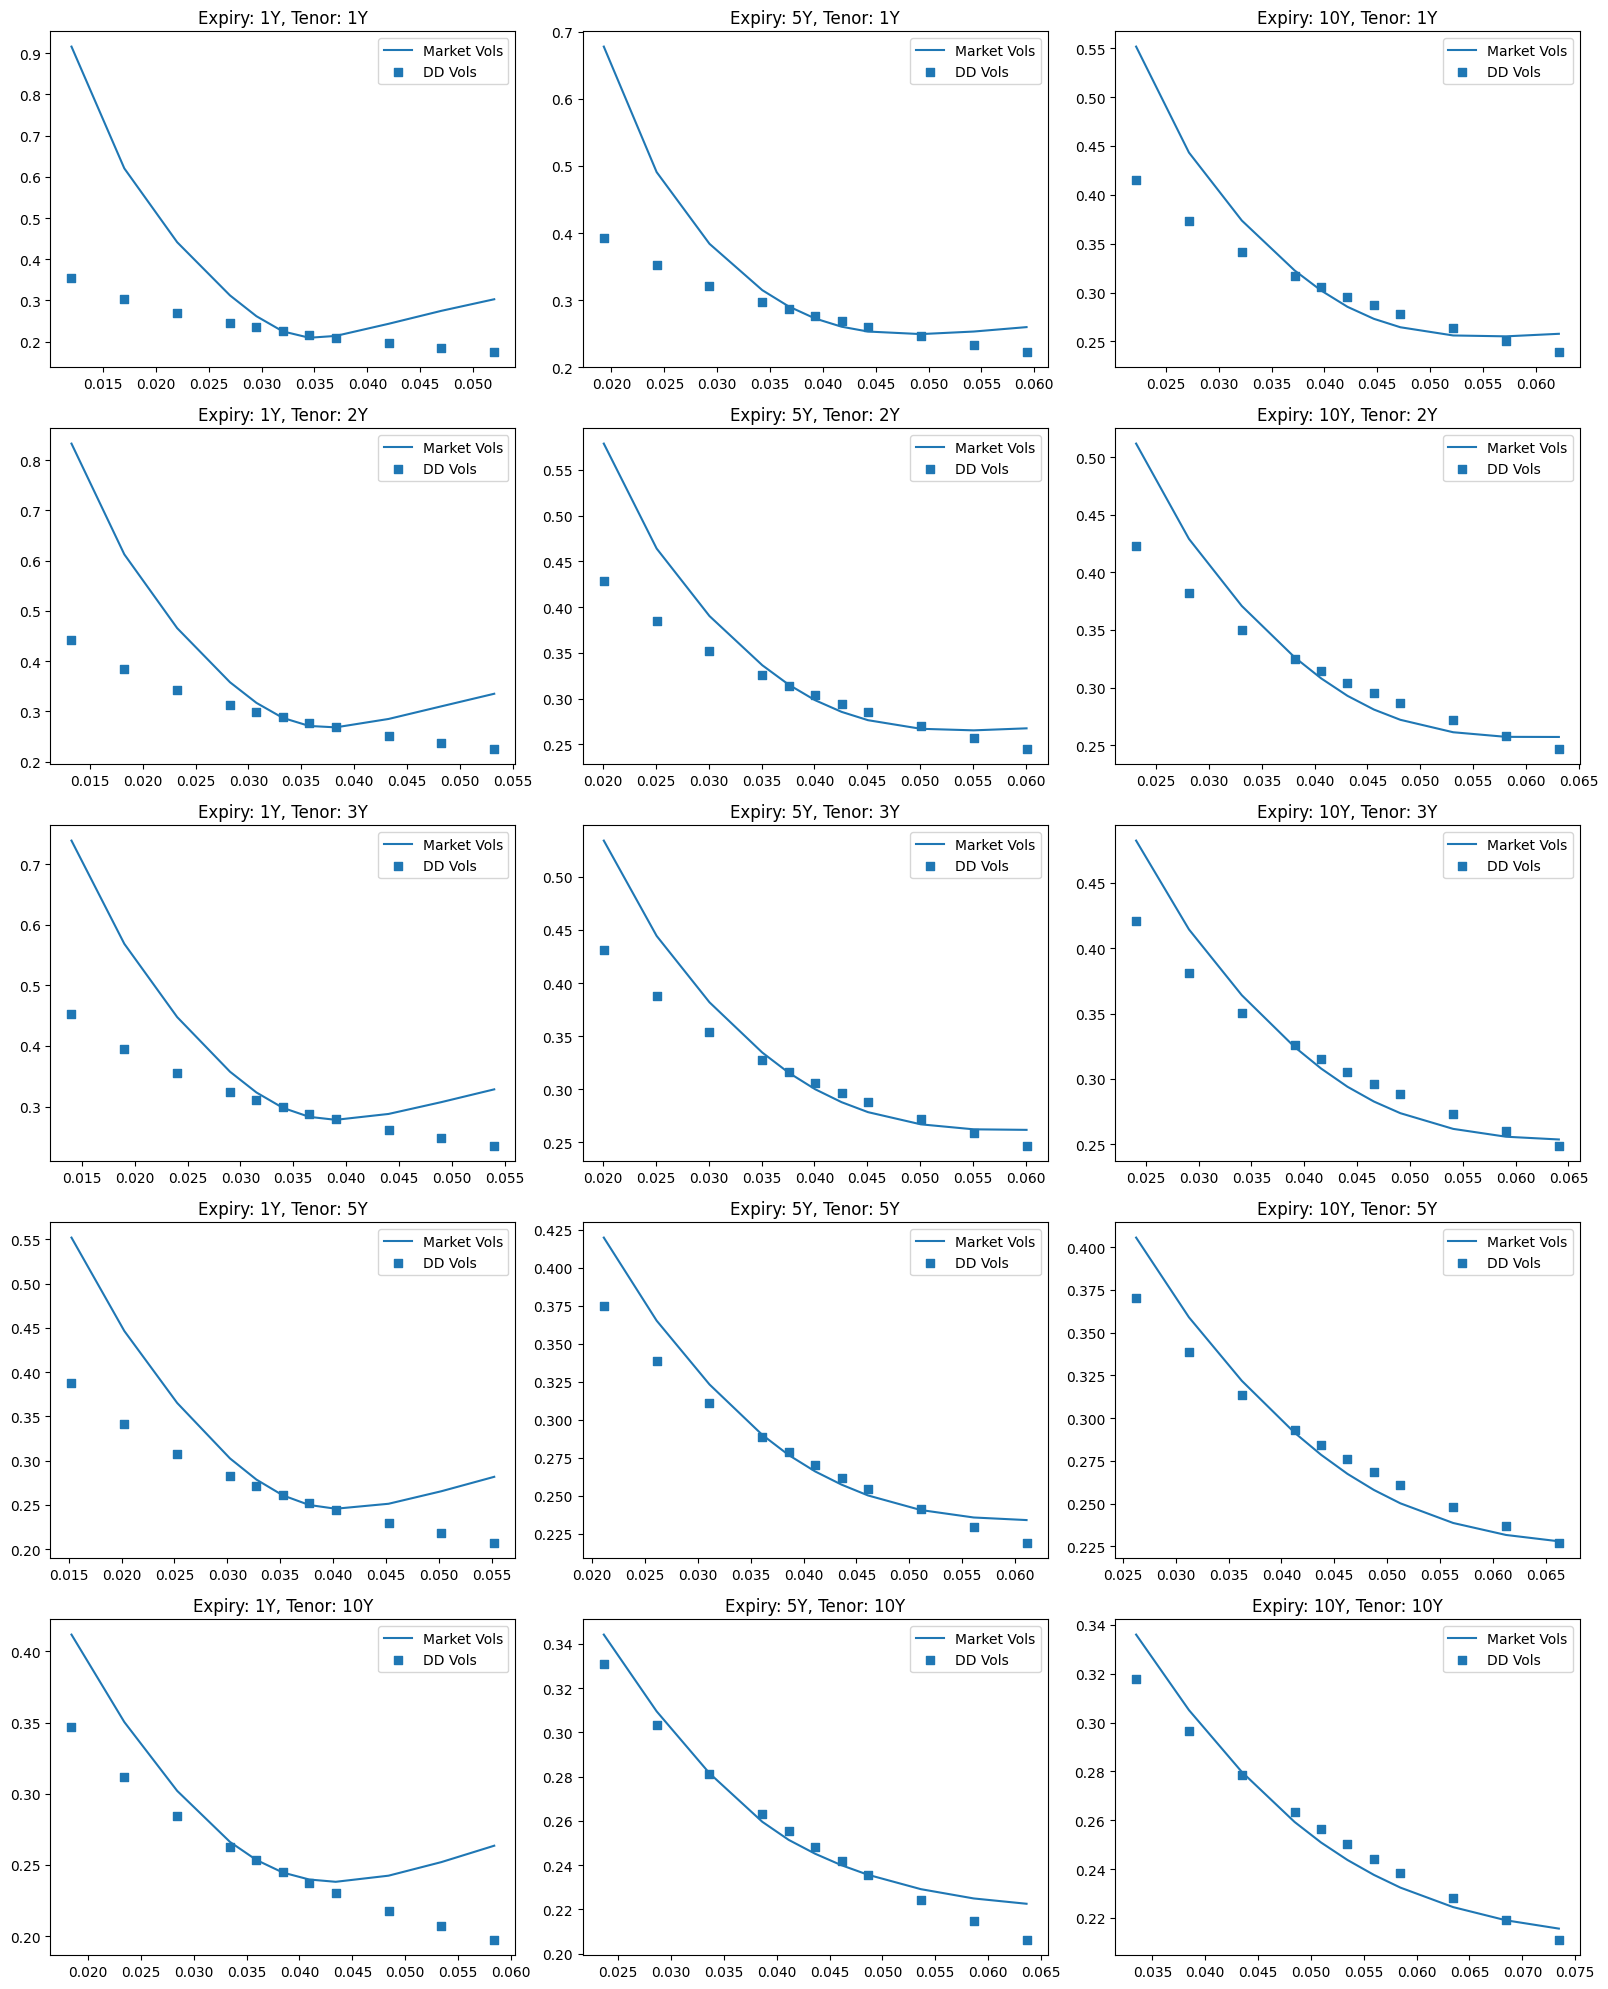

In [23]:
# plot the calibrated DD model with the market vols 

fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(16, 20))

for j, ex in enumerate(Expiry):
    for i, te in enumerate(Tenor):
        fwd = fsr.loc[ex, te]
        market_vols = swap.loc[(ex, te), :].values
        strikes = fwd + bps

        ex_int = int(ex.strip()[:-1])
        te_int = int(te.strip()[:-1])
        pvbp = 0.5 * sum(DF_semi_annual.OIS_DF[2*ex_int:(ex_int+te_int)*2])
        T = ex_int

        DD_vols = [volatility(fwd, i, pvbp, T, Cal_Sigma.loc[ex,te], Cal_Beta.loc[ex, te]) 
                   for i in strikes]

        axs[i, j].plot(strikes, market_vols, label='Market Vols')
        axs[i, j].scatter(strikes, DD_vols, marker="s", label='DD Vols')

        axs[i, j].set_title(f'Expiry: {ex}, Tenor: {te}')
        axs[i, j].legend()

plt.tight_layout()
plt.show()

## Question 2: SABR calibration

The SABR model is a widely-used option pricing model which effectively captures the implied volatility smile observed in the market. In this model, volatility is stochastic and follows zero-drift lognormal dynamics. The parameter $\alpha$ in the SABR model controls the weight of the lognormal and normal models, while $\nu$ represents the volatility of the model volatility and $\rho$ balances the price movement and the implied volatility.

To calibrate the SABR model accurately, we follow a similar procedure to the Displaced-Diffusion model calibration. First, we obtain the SABR model implied volatilities. Then, we ensure that the SABR model matches the implied volatilities observed in the market by minimizing the sum of the squared error terms between the market implied volatilities and the SABR implied volatilities. 

In [24]:
beta = 0.9

In [25]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    if F == K:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom
    return sabrsigma

In [26]:
def SABR_calibration(x, strikes, vols, F, T):
    error = 0.0
    for i, impled_vol in enumerate(vols):
        error += (impled_vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2
    return error

In [27]:
SABR_Alpha=pd.DataFrame(np.zeros((3,5)),index=Expiry,columns=Tenor)
SABR_Rho=pd.DataFrame(np.zeros((3,5)),index=Expiry,columns=Tenor)
SABR_Nu=pd.DataFrame(np.zeros((3,5)),index=Expiry,columns=Tenor)

In [28]:
SABR_Alpha

,1Y,2Y,3Y,5Y,10Y
1Y,0.0,0.0,0.0,0.0,0.0
5Y,0.0,0.0,0.0,0.0,0.0
10Y,0.0,0.0,0.0,0.0,0.0


In [29]:
initialGuess_sabr=[0.1,-0.5,0.5]

In [30]:
for ex in Expiry:
    for te in Tenor:             
        fwd = fsr.loc[ex, te]
        market_vol = swap.loc[(ex, te), :].values
        strikes = fwd + bps
    
        T=int(ex[:-1])
       
        res=least_squares(lambda x: SABR_calibration(x,
                                           strikes,
                                           market_vol,
                                           fwd,
                                           T),
                          initialGuess_sabr,
                          bounds=([0,-1,0],[np.inf,1,np.inf]))
        SABR_Alpha[te][ex]=res.x[0]
        SABR_Rho[te][ex]=res.x[1]
        SABR_Nu[te][ex]=res.x[2]

In [31]:
# SABR_Alpha

In [32]:
def SABR_vol(F, K, PVBP, T, alpha, beta, rho, nu):
    
    sigma = SABR(F, K, T, alpha, beta, rho, nu)
    if F <= K:
        price = Black76_Call(F, K, sigma, PVBP, T)
        impled_vol = fsolve(lambda x: price -
                        Black76_Call(F, K, x, PVBP, T),
                        0.5)
    else:
        price = Black76_Put(F, K, sigma, PVBP, T)
        impled_vol = fsolve(lambda x: price -
                        Black76_Put(F, K,x,PVBP, T),
                        0.5)
    return impled_vol[0]

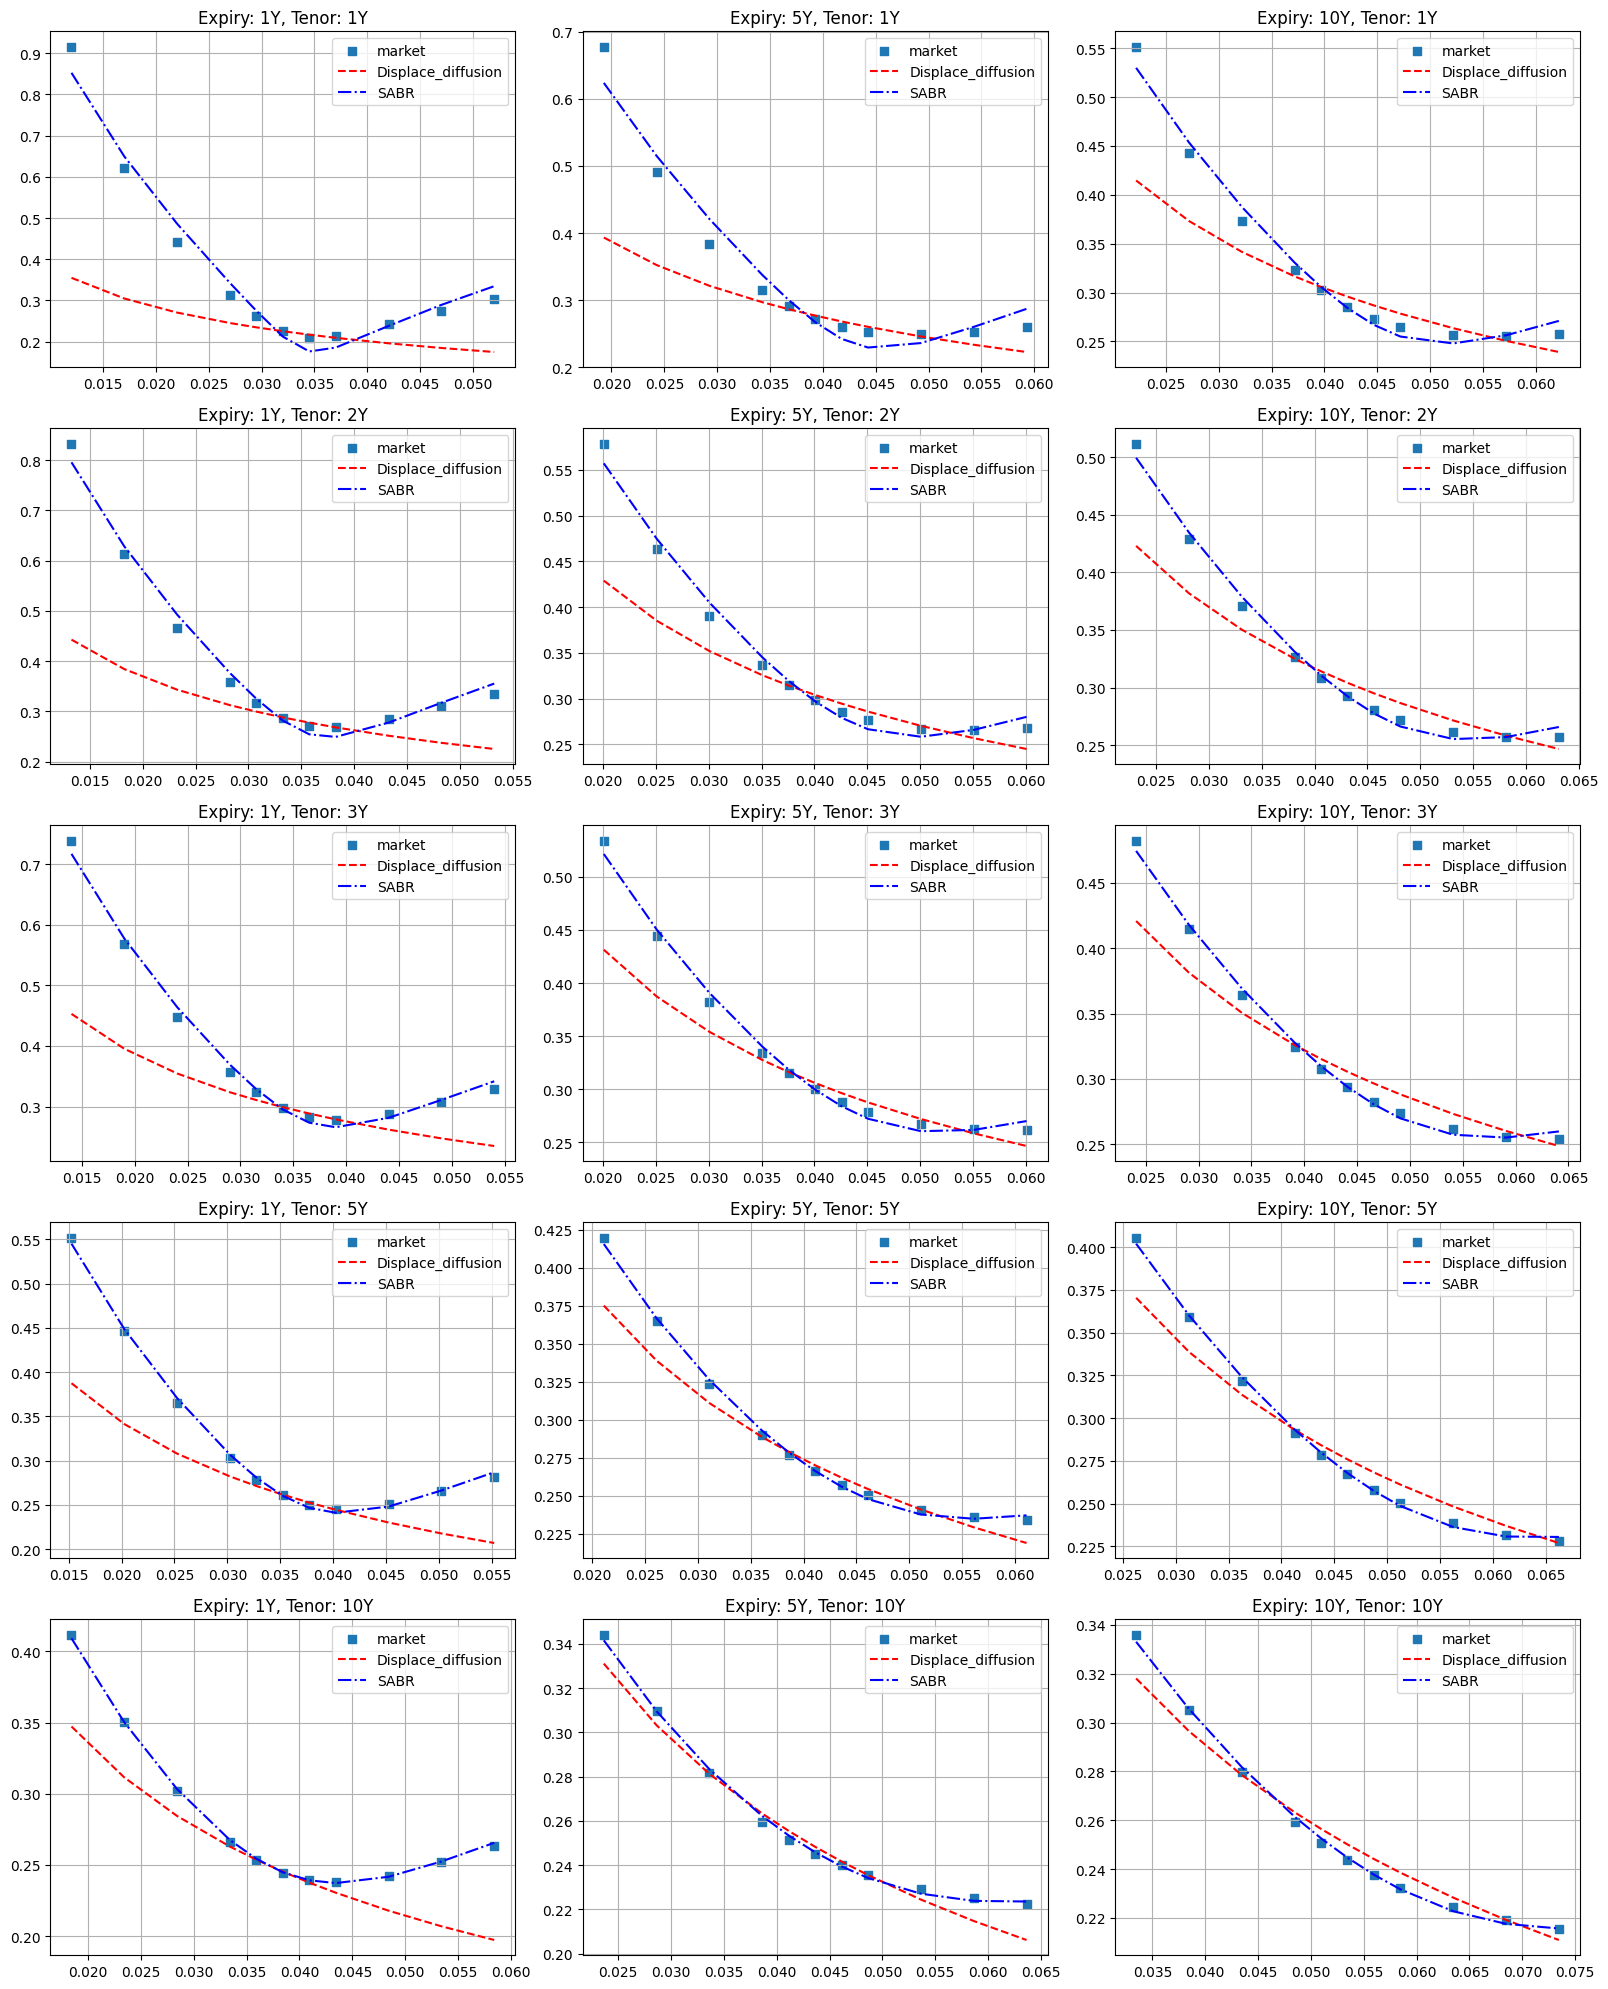

In [33]:
# plot the DD model and SABR model

fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(16, 20))

for j, ex in enumerate(Expiry):
    for i, te in enumerate(Tenor):
        fwd = fsr.loc[ex, te]
        market_vols = swap.loc[(ex, te), :].values
        strikes = fwd + bps

        ex_int = int(ex.strip()[:-1])
        te_int = int(te.strip()[:-1])
        pvbp = 0.5 * sum(DF_semi_annual.OIS_DF[2*ex_int:(ex_int+te_int)*2])
        T = ex_int

        DD_vols = [volatility(fwd, i, pvbp, T, Cal_Sigma.loc[ex,te], Cal_Beta.loc[ex, te]) 
                   for i in strikes]
        SABR_vols = [SABR_vol(fwd, i, PVBP, T, SABR_Alpha.loc[ex,te], 0.9,
                             SABR_Rho.loc[ex, te], SABR_Nu.loc[ex, te]) for i in strikes]

        axs[i,j].scatter(strikes, market_vols,marker = 's', label= 'market')
        axs[i,j].plot(strikes, DD_vols, '--r', label = 'Displace_diffusion')
        axs[i,j].plot(strikes, SABR_vols, '-.b', label = 'SABR')

        axs[i,j].set_title(f'Expiry: {ex}, Tenor: {te}')
        axs[i,j].legend()
        axs[i,j].grid()

plt.tight_layout()
plt.show()

In [34]:
SABR_Alpha.to_csv('SABR_alpha.csv')
SABR_Rho.to_csv('SABR_rho.csv')
SABR_Nu.to_csv('SABR_nu.csv')

## Question 3: Price the swaptions using calibrated Displaced-diffusion and SABR model

We set an interpolation function using cubic spline method to acquire calibrated sigma, alpha, beta, rho and nu for 2y x 10y and 8y x10y respectively, using the parameters we obtained from the two parts above.

### Payer 2y*10y

In [35]:
def interpol(x1,y1,x2,y2,x):
    return y1+(x-x1)*((y2-y1)/(x2-x1))

In [36]:
sigma_Pay = interpol(1,Cal_Sigma['10Y']['1Y'],5,Cal_Sigma['10Y']['5Y'],2)
beta_Pay = interpol(1,Cal_Beta['10Y']['1Y'],5,Cal_Beta['10Y']['5Y'],2)
alpha_Pay = interpol(1,SABR_Alpha['10Y']['1Y'],5,SABR_Alpha['10Y']['5Y'],2)
rho_Pay = interpol(1,SABR_Rho['10Y']['1Y'],5,SABR_Rho['10Y']['5Y'],2)
nu_Pay = interpol(1,SABR_Nu['10Y']['1Y'],5,SABR_Nu['10Y']['5Y'],2)

In [37]:
fwd1 = 0.03963437677316925
strikes=np.arange(0.01,0.081,0.01)
T = 2
pvbp1 = 0.5 * sum(DF_semi_annual.OIS_DF[2*2:(2+10)*2])

In [38]:
payer_DD = [DD_Call(fwd1, i, sigma_Pay, pvbp1, beta_Pay, T) for i in strikes]   
payer_SABR=[Black76_Call(fwd1,i,SABR(fwd1,i,T,alpha_Pay,0.9,rho_Pay,nu_Pay),pvbp1, T) for i in strikes]

In [39]:
payer_2x10 = pd.DataFrame({'Strikes':strikes, 'Displaced Diffusion':payer_DD,
                     'SABR': payer_SABR}).T
payer_2x10

,0,1,2,3,4,5,6,7
Strikes,0.010000,0.020000,0.030000,0.040000,0.050000,0.060000,0.070000,0.080000
Displaced Diffusion,0.288142,0.194936,0.112326,0.051345,0.017366,0.004106,0.000651,0.000067
SABR,0.289615,0.198313,0.115173,0.052170,0.021481,0.010869,0.006740,0.004745


In [40]:
payer_2x10.columns=payer_2x10.iloc[0]
payer_2x10 = payer_2x10.drop(['Strikes'], axis = 0)
payer_2x10

Strikes,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08
Displaced Diffusion,0.288142,0.194936,0.112326,0.051345,0.017366,0.004106,0.000651,0.000067
SABR,0.289615,0.198313,0.115173,0.052170,0.021481,0.010869,0.006740,0.004745


### Receiver 8y*10y

In [41]:
fwd2 = 0.04871114894211796
pvbp2 = 0.5 * sum(DF_semi_annual.OIS_DF[8*2:(8+10)*2])
T = 8

In [42]:
sigma_Rec = interpol(5,Cal_Sigma['10Y']['5Y'],10,Cal_Sigma['10Y']['10Y'],8)
beta_Rec = interpol(5,Cal_Beta['10Y']['5Y'],10,Cal_Beta['10Y']['10Y'],8)
alpha_Rec=interpol(5,SABR_Alpha['10Y']['5Y'],10,SABR_Alpha['10Y']['10Y'],8)
rho_Rec=interpol(5,SABR_Rho['10Y']['5Y'],10,SABR_Rho['10Y']['10Y'],8)
nu_Rec=interpol(5,SABR_Nu['10Y']['5Y'],10,SABR_Nu['10Y']['10Y'],8)

In [43]:
rec_DD = [DD_Put(fwd2, i, sigma_Rec, pvbp2, beta_Rec, T) for i in strikes]
rec_SABR=[Black76_Put(fwd2, i, SABR(fwd2,i,T,alpha_Rec,0.9,rho_Rec,nu_Rec), pvbp2, T) for i in strikes]

In [44]:
receiver_8x10 = pd.DataFrame({'Strikes':strikes, 'Displaced Diffusion':rec_DD,
                     'SABR': rec_SABR}).T
receiver_8x10

,0,1,2,3,4,5,6,7
Strikes,0.010000,0.020000,0.030000,0.040000,0.050000,0.060000,0.070000,0.080000
Displaced Diffusion,0.018985,0.033904,0.056649,0.088980,0.132050,0.186136,0.250582,0.323971
SABR,0.019194,0.038398,0.061147,0.090329,0.130409,0.186129,0.257247,0.338370


In [45]:
receiver_8x10.columns=receiver_8x10.iloc[0]
receiver_8x10 = receiver_8x10.drop(['Strikes'], axis = 0)
receiver_8x10

Strikes,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08
Displaced Diffusion,0.018985,0.033904,0.056649,0.088980,0.132050,0.186136,0.250582,0.323971
SABR,0.019194,0.038398,0.061147,0.090329,0.130409,0.186129,0.257247,0.338370


The data above implies that as the strikes become higher, the payer swaption would be cheaper, while it is the opposite for the receiver one. Furthermore, when k increases, receiver swaption priced with DD model would be closer to that with SABR model. 